In [19]:
# variation of skill with season
# variation of skill with initial WR
# variation of skill with ENSO

import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from keras.utils import to_categorical
# import visualkeras
# import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

import optuna
from optuna.samplers import TPESampler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import sys
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob 

sys.path.append("/glade/u/home/jhayron/WR_Predictability/3_MLModels/")
from model_builders_v2 import *
from sklearn import datasets, ensemble
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


# persistence performance

In [17]:
wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230824.csv',\
                index_col=0,names=['week0'],skiprows=1,parse_dates=True)
for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [80]:
acc_persistence = []

for wk in range(1,9):
    df_temp = df_shifts[[f'week{0}',f'week{wk}']].dropna()['2016':'2020']
    acc_persistence.append(accuracy_score(df_temp[f'week{0}'],df_temp[f'week{wk}']))

In [81]:
acc_persistence = np.array(acc_persistence)

# performance rf

In [82]:
path_models = '/glade/work/jhayron/Data4Predictability/models/ModelsRF/'
path_results = '/glade/work/jhayron/Data4Predictability/models/PredictionsRF/'

In [83]:
list_folders = np.sort(glob.glob('/glade/u/home/jhayron/WR_Predictability/4_PCA_Analysis/figures_2/*/'))
list_vars = [list_folders[i].split('/')[-2] for i in range(len(list_folders))]

list_folders = np.delete(np.array(list_folders),11)
list_vars = np.delete(np.array(list_vars),11)

for ivar,var in enumerate(list_vars):
    print(ivar,var)

0 IC_SODA
1 IT_SODA
2 MLD_SODA
3 OHC100_SODA
4 OHC200_SODA
5 OHC300_SODA
6 OHC50_SODA
7 OHC700_SODA
8 OLR_ERA5
9 SD_ERA5
10 SSH_SODA
11 SST_SODA
12 STL_1m_ERA5
13 STL_28cm_ERA5
14 STL_7cm_ERA5
15 STL_full_ERA5
16 SWVL_1m_ERA5
17 SWVL_28cm_ERA5
18 SWVL_7cm_ERA5
19 SWVL_full_ERA5
20 U10_ERA5
21 U200_ERA5
22 Z500_ERA5


In [84]:
list_files_scores_val = np.sort(glob.glob(f'{path_results}*_scores_val.npy'))
list_files_scores_test = np.sort(glob.glob(f'{path_results}*_scores_test.npy'))

In [85]:
names_vars = np.array([list_files_scores_val[i].split('/')[-1].split('_s')[0] for i in range(len(list_files_scores_val))])

In [86]:
indices_atmosphere = np.array([8,20,21,22,23])
indices_land = np.array([9,12,13,14,15,16,17,18,19,24])
indices_ocean = np.array([2,3,4,5,6,7,10,11,25])

In [87]:
weeks = np.arange(1,9)

In [88]:
path_figures_accuracy = 'figures_random_forest/accuracy/'

In [66]:
for ivar in indices_atmosphere:
    scores_val = np.load(list_files_scores_val[ivar])
    if names_vars[ivar]=='atm':
        plt.plot(weeks[1:],scores_val[1:]*100,label = names_vars[ivar],color='k')
    else:
        plt.plot(weeks[1:],scores_val[1:]*100,label = names_vars[ivar],alpha=0.8)
plt.plot(weeks[1:],acc_persistence[1:]*100,label = 'persistence',color='gray',ls = '--')
plt.ylim(20,27)
plt.grid(alpha=0.3)
plt.ylabel('Accuracy [%]')
# plt.xlabel('Duration (weeks)')
plt.title('Seasonal changes in accuracy: ',loc='left')
plt.legend(bbox_to_anchor=(1, 1.0))
plt.savefig(f'{path_figures_accuracy}atm_val_acc.png',bbox_inches='tight')

plt.close('all')
for ivar in indices_ocean:
    scores_val = np.load(list_files_scores_val[ivar])
    if names_vars[ivar]=='ocn':
        plt.plot(weeks[1:],scores_val[1:]*100,label = names_vars[ivar],color='k')
    else:
        plt.plot(weeks[1:],scores_val[1:]*100,label = names_vars[ivar],alpha=0.8)
plt.plot(weeks[1:],acc_persistence[1:]*100,label = 'persistence',color='gray',ls = '--')
plt.ylim(20,27)
plt.grid(alpha=0.3)
plt.ylabel('Accuracy [%]')
# plt.xlabel('Duration (weeks)')
plt.title('Seasonal changes in accuracy: ',loc='left')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.savefig(f'{path_figures_accuracy}ocn_val_acc.png',bbox_inches='tight')

plt.close('all')
for ivar in indices_land:
    scores_val = np.load(list_files_scores_val[ivar])
    if names_vars[ivar]=='lnd':
        plt.plot(weeks[1:],scores_val[1:]*100,label = names_vars[ivar],color='k')
    else:
        plt.plot(weeks[1:],scores_val[1:]*100,label = names_vars[ivar],alpha=0.8)
plt.plot(weeks[1:],acc_persistence[1:]*100,label = 'persistence',color='gray',ls = '--')
plt.ylim(20,27)
plt.grid(alpha=0.3)
plt.ylabel('Accuracy [%]')
# plt.xlabel('Duration (weeks)')
plt.title('Seasonal changes in accuracy: ',loc='left')
plt.legend(bbox_to_anchor=(1., 1))
plt.savefig(f'{path_figures_accuracy}lnd_val_acc.png',bbox_inches='tight')
plt.close('all')

In [89]:
for ivar in indices_atmosphere:
    scores_test = np.load(list_files_scores_test[ivar])
    if names_vars[ivar]=='atm':
        plt.plot(weeks[1:],scores_test[1:]*100,label = names_vars[ivar],color='k')
    else:
        plt.plot(weeks[1:],scores_test[1:]*100,label = names_vars[ivar],alpha=0.8)
plt.plot(weeks[1:],acc_persistence[1:]*100,label = 'persistence',color='gray',ls = '--')
plt.ylim(16,32)
plt.grid(alpha=0.3)
plt.ylabel('Accuracy [%]')
# plt.xlabel('Duration (weeks)')
plt.title('Seasonal changes in accuracy: ',loc='left')
plt.legend(bbox_to_anchor=(1, 1.0))
plt.savefig(f'{path_figures_accuracy}atm_test_acc.png',bbox_inches='tight')

plt.close('all')
for ivar in indices_ocean:
    scores_test = np.load(list_files_scores_test[ivar])
    if names_vars[ivar]=='ocn':
        plt.plot(weeks[1:],scores_test[1:]*100,label = names_vars[ivar],color='k')
    else:
        plt.plot(weeks[1:],scores_test[1:]*100,label = names_vars[ivar],alpha=0.8)
plt.plot(weeks[1:],acc_persistence[1:]*100,label = 'persistence',color='gray',ls = '--')
plt.ylim(16,32)
plt.grid(alpha=0.3)
plt.ylabel('Accuracy [%]')
# plt.xlabel('Duration (weeks)')
plt.title('Seasonal changes in accuracy: ',loc='left')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.savefig(f'{path_figures_accuracy}ocn_test_acc.png',bbox_inches='tight')

plt.close('all')
for ivar in indices_land:
    scores_test = np.load(list_files_scores_test[ivar])
    if names_vars[ivar]=='lnd':
        plt.plot(weeks[1:],scores_test[1:]*100,label = names_vars[ivar],color='k')
    else:
        plt.plot(weeks[1:],scores_test[1:]*100,label = names_vars[ivar],alpha=0.8)
plt.plot(weeks[1:],acc_persistence[1:]*100,label = 'persistence',color='gray',ls = '--')
plt.ylim(16,32)
plt.grid(alpha=0.3)
plt.ylabel('Accuracy [%]')
# plt.xlabel('Duration (weeks)')
plt.title('Seasonal changes in accuracy: ',loc='left')
plt.legend(bbox_to_anchor=(1., 1))
plt.savefig(f'{path_figures_accuracy}lnd_test_acc.png',bbox_inches='tight')
plt.close('all')

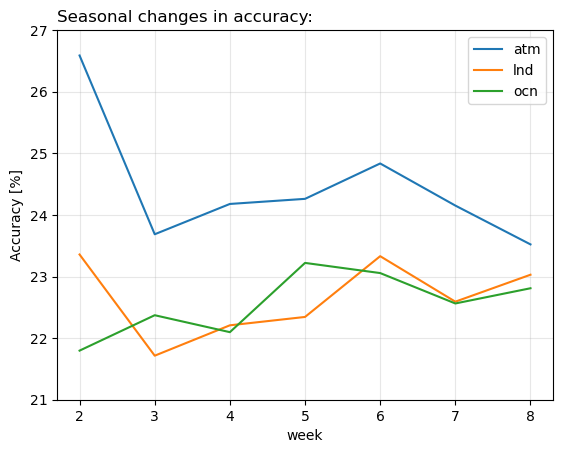

In [79]:
for ivar in [23,24,25]:
    scores_val = np.load(list_files_scores_val[ivar])
    # if names_vars[ivar]=='lnd':
    #     plt.plot(weeks,scores_val,label = names_vars[ivar],color='k')
    # else:
    plt.plot(weeks[1:],scores_val[1:]*100,label = names_vars[ivar])
        
plt.xlabel('week')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(21,27)
plt.grid(alpha=0.3)
plt.ylabel('Accuracy [%]')
# plt.xlabel('Duration (weeks)')
plt.title('Seasonal changes in accuracy: ',loc='left')
plt.savefig(f'{path_figures_accuracy}acc_comps_val.png',bbox_inches='tight')
# plt.close('all')

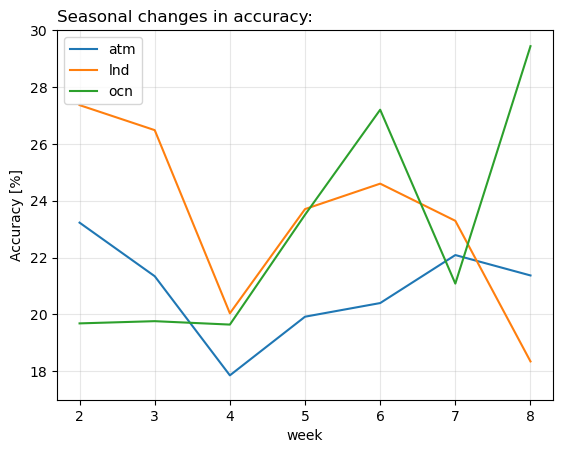

In [76]:
for ivar in [23,24,25]:
    scores_test = np.load(list_files_scores_test[ivar])
    # if names_vars[ivar]=='lnd':
    #     plt.plot(weeks,scores_val,label = names_vars[ivar],color='k')
    # else:
    plt.plot(weeks[1:],scores_test[1:]*100,label = names_vars[ivar])
        
plt.xlabel('week')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(17,30)
plt.grid(alpha=0.3)
plt.ylabel('Accuracy [%]')
# plt.xlabel('Duration (weeks)')
plt.title('Seasonal changes in accuracy: ',loc='left')
plt.savefig(f'{path_figures_accuracy}acc_comps_test.png',bbox_inches='tight')
# plt.close('all')